# Roberta Tests for LLM Project

In [1]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from datasets import load_dataset
import torch
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt

/home/hpate061/anaconda3/envs/Research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading the BigBench-epistemic Rasoning dataset
raw_dataset = load_dataset("tasksource/bigbench", "epistemic_reasoning")
choices = ["entailment", "non-entailment"]
dataset = [] 
for split_ in ["validation", "train"]:
    for dp in raw_dataset[split_]:
        targets = dp["targets"]
        assert len(targets) == 1
        assert targets[0] in choices
        dataset.append((dp["inputs"], targets[0]))

In [3]:
dataset[1]

("Identify the relation between the following premises and hypotheses, choosing from the options 'entailment' or 'non-entailment'.\n\nPremise: Michael suspects that Richard recognizes that one woman with jeans, gray shirt and sandals; with girl in all pink watching a white ball float in midair. Hypothesis: Michael suspects that one woman with jeans, gray shirt and sandals; with girl in all pink watching a white ball float in midair.\nRelation:",
 'entailment')

In [4]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [5]:
tokenized_data = tokenizer([item[0] for item in dataset], padding=True, truncation=True, return_tensors='pt')
labels = torch.tensor([1 if item[1] == 'entailment' else 0 for item in dataset])


In [6]:
# DataLoader 
from torch.utils.data import DataLoader

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)
    
data_loader = DataLoader(Dataset(tokenized_data, labels), batch_size=8)

In [7]:
correct = 0
total = 0
total_loss = 0

for batch in data_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    labels = batch['labels']
    outputs = model(**batch)
    loss = outputs.loss
    logits = outputs.logits
    
    total_loss += loss.item()
    total += labels.size(0)
    correct += (torch.argmax(logits, -1) == labels).sum().item()
    
print("Accuracy: ", correct/total)
print("Loss: ", total_loss/total)

Accuracy:  0.6295
Loss:  0.08623899921774864


# Editing the Model

In [8]:
model_to_edit = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# print layers of the model and size of the layers
for name, param in model_to_edit.named_parameters():
    print(name, param.size())


roberta.embeddings.word_embeddings.weight torch.Size([50265, 768])
roberta.embeddings.position_embeddings.weight torch.Size([514, 768])
roberta.embeddings.token_type_embeddings.weight torch.Size([1, 768])
roberta.embeddings.LayerNorm.weight torch.Size([768])
roberta.embeddings.LayerNorm.bias torch.Size([768])
roberta.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
roberta.encoder.layer.0.attention.self.query.bias torch.Size([768])
roberta.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
roberta.encoder.layer.0.attention.self.key.bias torch.Size([768])
roberta.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
roberta.encoder.layer.0.attention.self.value.bias torch.Size([768])
roberta.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
roberta.encoder.layer.0.attention.output.dense.bias torch.Size([768])
roberta.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
roberta.encoder.layer.0.attention.output.

## Stacking 1

In [10]:
selected_layers = [7, 8, 9, 10]
tensor = []
for layer in selected_layers:
    query_weights = model_to_edit.roberta.encoder.layer[layer].attention.self.query.weight.detach().cpu().numpy()
    key_weights = model_to_edit.roberta.encoder.layer[layer].attention.self.key.weight.detach().cpu().numpy()
    value_weights = model_to_edit.roberta.encoder.layer[layer].attention.self.value.weight.detach().cpu().numpy()
    output_weights = model_to_edit.roberta.encoder.layer[layer].attention.output.dense.weight.detach().cpu().numpy()
    
    # Stacking the weights for each selected layer
    stacked_weights = np.stack([query_weights, key_weights, value_weights, output_weights])
    tensor.append(stacked_weights)
    
stacked_tensor = np.stack(tensor)
    

In [11]:
stacked_tensor.shape

(4, 4, 768, 768)

In [12]:

def plot_reconstruction_error(tensor, max_desired_rank):
    rank_range = range(1, max_desired_rank + 1)
    reconstruction_errors = []
    for rank in rank_range:
        print(rank)
        factors = tl.decomposition.parafac(tensor, rank=rank)
        reconstructed_tensor = tl.kruskal_to_tensor(factors)
        reconstruction_error = tl.norm(tensor - reconstructed_tensor)
        reconstruction_errors.append(reconstruction_error)
    plt.plot(rank_range, reconstruction_errors)
    plt.xlabel('Rank')
    plt.ylabel('Reconstruction Error')
    plt.show()


    

1


2
3
4


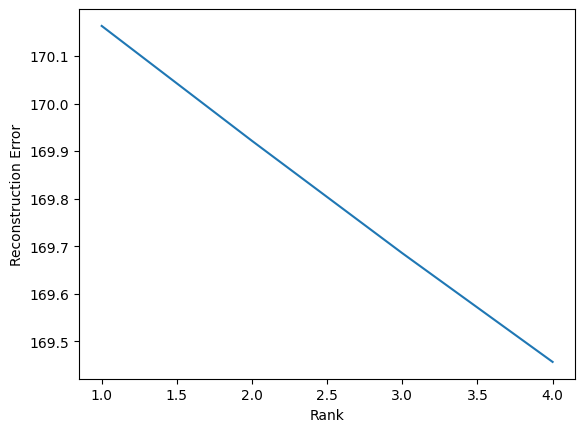

In [13]:
plot_reconstruction_error(stacked_tensor, 4)

In [14]:
# Decomposing the tensor
factors = tl.decomposition.parafac(stacked_tensor, rank=2)
reconstructed_tensor = tl.kruskal_to_tensor(factors)
reconstruction_error = tl.norm(stacked_tensor - reconstructed_tensor)
print(reconstruction_error)


169.92155


In [15]:
reconstructed_tensor.shape

(4, 4, 768, 768)

In [16]:
# replace the weights of the selected layers with the reconstructed weights

for i, layer in enumerate(selected_layers):
    layer_weights = reconstructed_tensor[i]
    
    reconstructed_query_weights = layer_weights[0]
    reconstructed_key_weights = layer_weights[1]
    reconstructed_value_weights = layer_weights[2]
    reconstructed_output_weights = layer_weights[3]
    
    model_to_edit.roberta.encoder.layer[layer].attention.self.query.weight = torch.nn.Parameter(torch.tensor(reconstructed_query_weights))
    model_to_edit.roberta.encoder.layer[layer].attention.self.key.weight = torch.nn.Parameter(torch.tensor(reconstructed_key_weights))
    model_to_edit.roberta.encoder.layer[layer].attention.self.value.weight = torch.nn.Parameter(torch.tensor(reconstructed_value_weights))
    model_to_edit.roberta.encoder.layer[layer].attention.output.dense.weight = torch.nn.Parameter(torch.tensor(reconstructed_output_weights))

model_to_edit.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [17]:
for batch in data_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    labels = batch['labels']
    outputs = model_to_edit(**batch)
    loss = outputs.loss
    logits = outputs.logits
    
    total_loss += loss.item()
    total += labels.size(0)
    correct += (torch.argmax(logits, -1) == labels).sum().item()
    
print("Accuracy: ", correct/total)
print("Loss: ", total_loss/total)



Accuracy:  0.5065
Loss:  0.08651590424776077


# Stacking 2

In [18]:
selected_layers = [7, 8, 9, 10]
tensor = []
for layer in selected_layers:
    query_weights = model_to_edit.roberta.encoder.layer[layer].attention.self.query.weight.detach().cpu().numpy()
    key_weights = model_to_edit.roberta.encoder.layer[layer].attention.self.key.weight.detach().cpu().numpy()
    value_weights = model_to_edit.roberta.encoder.layer[layer].attention.self.value.weight.detach().cpu().numpy()
    output_weights = model_to_edit.roberta.encoder.layer[layer].attention.output.dense.weight.detach().cpu().numpy()
    
    layer_block = np.array([query_weights, key_weights, value_weights, output_weights])
    tensor.append(layer_block)
    
stacked_tensor = np.vstack(tensor)

In [19]:
stacked_tensor.shape

(16, 768, 768)

1
2
3
4


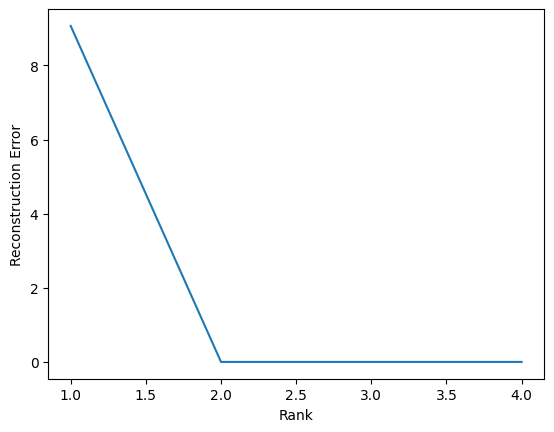

In [20]:
plot_reconstruction_error(stacked_tensor, 4)

In [21]:
decomposed = tl.decomposition.parafac(stacked_tensor, rank=2)
reconstructed_tensor = tl.kruskal_to_tensor(decomposed)
reconstruction_error = tl.norm(stacked_tensor - reconstructed_tensor)
print(reconstruction_error)

5.86198e-06


In [22]:
unstacked_reconstructed_tensor = stacked_tensor.reshape(-1, 4, 768, 768)
unstacked_reconstructed_tensor.shape



(4, 4, 768, 768)

In [23]:
for i, layer in enumerate(selected_layers):
    layer_weights = unstacked_reconstructed_tensor[i]
    
    reconstructed_query_weights = layer_weights[0]
    reconstructed_key_weights = layer_weights[1]
    reconstructed_value_weights = layer_weights[2]
    reconstructed_output_weights = layer_weights[3]
    
    model_to_edit.roberta.encoder.layer[layer].attention.self.query.weight = torch.nn.Parameter(torch.tensor(reconstructed_query_weights))
    model_to_edit.roberta.encoder.layer[layer].attention.self.key.weight = torch.nn.Parameter(torch.tensor(reconstructed_key_weights))
    model_to_edit.roberta.encoder.layer[layer].attention.self.value.weight = torch.nn.Parameter(torch.tensor(reconstructed_value_weights))
    model_to_edit.roberta.encoder.layer[layer].attention.output.dense.weight = torch.nn.Parameter(torch.tensor(reconstructed_output_weights))
    
model_to_edit.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [24]:
for batch in data_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    labels = batch['labels']
    outputs = model_to_edit(**batch)
    loss = outputs.loss
    logits = outputs.logits
    
    total_loss += loss.item()
    total += labels.size(0)
    correct += (torch.argmax(logits, -1) == labels).sum().item()
    
print("Accuracy: ", correct/total)

print("Loss: ", total_loss/total)


Accuracy:  0.4655
Loss:  0.08660820592443148
